In [3]:
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2, 4, 8, 8*np.sqrt(2)),
        K=10,
        alpha=25,
        L=1,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [4]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


In [9]:
import os, multiprocessing
from os.path import join, isfile
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
import scipy.ndimage
import skimage.color
from numpy.random import default_rng
import matplotlib.pyplot as plt
from skimage import io

def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.
    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''
    filter_scales = opts.filter_scales
    # ----- TODO -----
     
    #print('filter_scales :',filter_scales)
    if len(img.shape)>=3:
        H,W,C=img.shape
    else:
        H,W=img.shape
        C=1
        
    Filter_size=4

    #2.Make sure if the channels are 3 or not and if less we take care of the grayscale images
    if C==1: # grey 
        img=np.expand_dims(img, axis=2)
        #print("Dimension Expansion :",img.shape)
        img = np.tile(img,(1,1,3))
        H,W,C=img.shape
        #print("in filtering :",img.shape)
    if C == 4: # special case
        img = img[:,:,0:3]
        H,W,C=img.shape
        
    #1.Make sure to noramlize the image first by checking that entries in image are float and with range 0 1
    if (type(img[0,0,0])==int): 
        img = img.astype('float') / 255
    elif (np.amax(img) > 1.0):
        img = img.astype('float') / 255    
           
    #3.We convert the image to skimage.color.rgb2lab()  
    img=skimage.color.rgb2lab(img)
      
    #now the shape is (H,W,3F*2) cause of the 2 filter scales that we have
    filter_responses=np.zeros((H,W,C*len(filter_scales)*Filter_size)) 
    #print('Original shape :',img.shape)
    #print('filter_responses shape :',filter_responses.shape)
    #4.We apply padding across the edges of the filter responses carefully
    
    c=0       
    
    for i in range(img.shape[2]):#Looping through each channel
        for j in range(len(filter_scales)):#For each of the filter scales we have to calculate this 
            filter_responses[:,:,c]=scipy.ndimage.gaussian_filter(img[:,:,i], sigma=filter_scales[j])
            filter_responses[:,:,c+3]=scipy.ndimage.gaussian_laplace(img[:,:,i], sigma=filter_scales[j])
            filter_responses[:,:,c+6]=scipy.ndimage.filters.gaussian_filter(img[:,:,i], sigma=filter_scales[j],order=[0,1])  
            filter_responses[:,:,c+9]=scipy.ndimage.filters.gaussian_filter(img[:,:,i], sigma=filter_scales[j],order=[1,0])
            c=c+C*Filter_size
        c=i+1
    return filter_responses



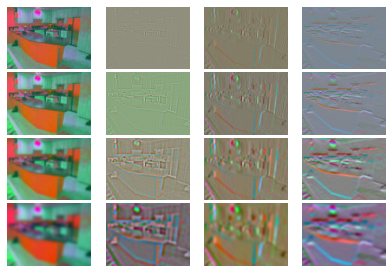

In [10]:
opts.filter_scales = [1, 2, 4, 8]
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

In [11]:
from numpy.random import default_rng

def compute_dictionary_one_image(img_path, opts):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """
#     opts, idx, img_path = args
    # ----- TODO -----
    
    alpha = opts.alpha
    
    img = io.imread('../data/' + img_path)
    img = img.astype('float')/255
    
    filter_responses = extract_filter_responses(opts, img)
    H, W, C = filter_responses.shape
    
    responses = np.reshape(filter_responses, (H*W, C))
    
    random = default_rng()
    joints = random.choice(H*W, size=alpha, replace = False)
    
    responses = responses[joints, :]
    
    return responses



def compute_dictionary(opts, n_worker=1):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    # ----- TODO -----

    img_response=compute_dictionary_one_image(os.path.join(opts.data_dir,(train_files[0])),opts)
    img_stack=np.zeros((0,img_response.shape[1]))
    for i in range(len(train_files)):
        img_response=compute_dictionary_one_image(os.path.join(opts.data_dir,(train_files[i])),opts)
        img_stack=np.vstack((img_stack,img_response))
        print(img_stack.shape)
        
    kmeans = KMeans(n_clusters=K,n_jobs=-1).fit(img_stack)
    dictionary = kmeans.cluster_centers_
    np.save('dictionary.npy',dictionary)

    return dictionary

In [ ]:
n_cpu = get_num_CPU()
compute_dictionary(opts, n_worker=n_cpu)

(25, 48)
(50, 48)
(75, 48)
(100, 48)
(125, 48)
(150, 48)
(175, 48)
(200, 48)
(225, 48)
(250, 48)
(275, 48)
(300, 48)
(325, 48)
(350, 48)
(375, 48)
(400, 48)
(425, 48)
(450, 48)
(475, 48)
(500, 48)
(525, 48)
(550, 48)
(575, 48)
(600, 48)
(625, 48)
(650, 48)
(675, 48)
(700, 48)
(725, 48)
(750, 48)
(775, 48)
(800, 48)
(825, 48)
(850, 48)
(875, 48)
(900, 48)
(925, 48)
(950, 48)
(975, 48)
(1000, 48)
(1025, 48)
(1050, 48)
(1075, 48)
(1100, 48)
(1125, 48)
(1150, 48)
(1175, 48)
(1200, 48)
(1225, 48)
(1250, 48)
(1275, 48)
(1300, 48)
(1325, 48)
(1350, 48)
(1375, 48)
(1400, 48)
(1425, 48)
(1450, 48)
(1475, 48)
(1500, 48)
(1525, 48)
(1550, 48)
(1575, 48)
(1600, 48)
(1625, 48)
(1650, 48)
(1675, 48)
(1700, 48)
(1725, 48)
(1750, 48)
(1775, 48)
(1800, 48)
(1825, 48)
(1850, 48)
(1875, 48)
(1900, 48)
(1925, 48)
(1950, 48)
(1975, 48)
(2000, 48)
(2025, 48)
(2050, 48)
(2075, 48)
(2100, 48)
(2125, 48)
(2150, 48)
(2175, 48)
(2200, 48)
(2225, 48)
(2250, 48)
(2275, 48)
(2300, 48)
(2325, 48)
(2350, 48)
(2375, 4

(18025, 48)
(18050, 48)
(18075, 48)
(18100, 48)
(18125, 48)
(18150, 48)
(18175, 48)
(18200, 48)
(18225, 48)
(18250, 48)
(18275, 48)
(18300, 48)
(18325, 48)
(18350, 48)
(18375, 48)
(18400, 48)
(18425, 48)
(18450, 48)
(18475, 48)
(18500, 48)
(18525, 48)
(18550, 48)
(18575, 48)
(18600, 48)
(18625, 48)
(18650, 48)
(18675, 48)
(18700, 48)
(18725, 48)
(18750, 48)
(18775, 48)
(18800, 48)
(18825, 48)
(18850, 48)
(18875, 48)
(18900, 48)
(18925, 48)
(18950, 48)
(18975, 48)
(19000, 48)
(19025, 48)
(19050, 48)
(19075, 48)
(19100, 48)
(19125, 48)
(19150, 48)
(19175, 48)
(19200, 48)
(19225, 48)
(19250, 48)
(19275, 48)
(19300, 48)
(19325, 48)
(19350, 48)
(19375, 48)
(19400, 48)
(19425, 48)
(19450, 48)
(19475, 48)
(19500, 48)
(19525, 48)
(19550, 48)
(19575, 48)
(19600, 48)
(19625, 48)
(19650, 48)
(19675, 48)
(19700, 48)
(19725, 48)
(19750, 48)
(19775, 48)
(19800, 48)
(19825, 48)
(19850, 48)
(19875, 48)
(19900, 48)
(19925, 48)
(19950, 48)
(19975, 48)
(20000, 48)
(20025, 48)
(20050, 48)
(20075, 48)
(201

In [24]:
import os, math, multiprocessing
from os.path import join
from copy import copy
from opts import get_opts
import numpy as np
from PIL import Image
# from image_split import split
# import visual_words
from PIL import Image
import scipy.ndimage
import skimage.color
import imageio
import matplotlib.pyplot as plt
import sklearn.cluster
import scipy.spatial.distance
import util
import numpy as np
from sklearn.metrics import confusion_matrix

def get_feature_from_wordmap(opts, wordmap):
    '''
    Compute histogram of visual words.
    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)
    [output]
    * hist: numpy.ndarray of shape
    '''
    opts = get_opts()
    K = opts.K
    # ----- TODO -----
    H,W= np.shape(wordmap)
    data=np.reshape(wordmap,(H*W,1))
    hist_bins=np.linspace(0, K, num=K+1, endpoint=True)                  
    hist1, bin_edge = np.histogram(data, bins=hist_bins)
    hist=hist1/np.linalg.norm(hist1,ord=1)
    hist = np.reshape(hist,(1,K))
    #print('complete5')
    return (hist)


def get_feature_from_wordmap_SPM(opts, wordmap):
    '''
    Compute histogram of visual words using spatial pyramid matching.
    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)
    [output]
    * hist_all: numpy.ndarray of shape (K*(4^L-1)/3)
    '''
    H,W= np.shape(wordmap)
    opts = get_opts()    
    K = opts.K
    L = opts.L

    weights = []
    for l in range(L):
        if l == 0 or l == 1:
            weights.append(2**(-(L-1)))
        else:
            weights.append(2**(l-L))
    hist_all= np.array([], dtype=np.int64).reshape(1,0)
    for i in range(len(weights)):
        layer = len(weights)-1-i
        weight = weights[len(weights)-1-i]
        sec_H = int(H/(2**layer))
        sec_W = int(W/(2**layer))
        for row in range(2**layer):
            for col in range(2**layer):
                subword = wordmap[sec_H*row:sec_H*(row+1),sec_W*col:sec_W*(col+1)]
                hist = get_feature_from_wordmap(opts,subword)
                hist_all = np.hstack([ hist_all,hist*weight])
    #print('complete6')
    return hist_all

    
def get_image_feature(opts, img_path, dictionary):
    '''
    Extracts the spatial pyramid matching feature.
    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)
    [output]
    * feature: numpy.ndarray of shape (K)
    '''
    opts = get_opts()
    img=imageio.imread('../data/'+img_path)
    img=img.astype('float')/255

    wordmap = visual_words.get_visual_words(opts, img, dictionary)
    feature = get_feature_from_wordmap_SPM(opts, wordmap)
    #print('complete7')
    return feature

def build_recognition_system(opts, n_worker=1):
    '''
    Creates a trained recognition system by generating training features from all training images.
    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel
    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    '''
    opts = get_opts()
    data_dir = opts.data_dir
    out_dir = opts.out_dir
    SPM_layer_num = opts.L

    train_files = open(join(data_dir, 'train_files.txt')).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, 'train_labels.txt'), np.int32)
    dictionary = np.load(join(out_dir, 'dictionary.npy'))

    # ----- TODO -----
    train_data = np.asarray(train_files)
    K = dictionary.shape[0]
    n_train = train_data.shape[0]
    labels = np.asarray(train_labels)
    M = int(K*(4**SPM_layer_num-1)/3)
    features=np.empty(M).reshape((1,M))
    for i in range(n_train):
        img_path = train_data[i]
        feat = get_image_feature(opts,img_path,dictionary) 
        features= np.vstack([features, feat]) 
    np.save('trained_system.npy', features)
    np.save('labels.npy', labels)
    np.savez('trained_system.npz',features = features,labels = labels,dictionary = dictionary,SPM_layer_num = SPM_layer_num)
    #print('complete8')


def distance_to_set(word_hist, histograms):
    '''
    Compute similarity between a histogram of visual words with all training image histograms.
    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)
    [output]
    * sim: numpy.ndarray of shape (N)
    '''

    # ----- TODO -----
    intersection = np.minimum(word_hist,histograms)
    similarity = np.sum(intersection,axis = 1)
    #print('complete9')
    return similarity
    
def evaluate_recognition_system(opts, n_worker=1):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.
    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel
    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    opts = get_opts()
    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, 'trained_system.npz'))
    dictionary = trained_system['dictionary']
    features = trained_system['features']

    train_labels = trained_system['labels']

    
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system['SPM_layer_num']

    test_files = open(join(data_dir, 'test_files.txt')).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, 'test_labels.txt'), np.int32)

    # ----- TODO -----
    test_data  = np.asarray(test_files)
    test_data=test_data.astype(str)
    test_labels = np.asarray(test_labels)
    n_test = len(test_files)

    
    predict_labels=list()
    ii=0
    for t in range(n_test):
        img_path =  test_data[t]
        test_feature = get_image_feature(opts,img_path,dictionary)
        similarity = distance_to_set(test_feature,features)
        idx = np.argmax(similarity)
        print(idx)
        ii+=1
        print('count of idx',ii)
        pl = train_labels[idx]
        predict_labels.append(pl)
    confusion = np.zeros((8,8))
    count=0
    for i in range(n_test):
        x=predict_labels[i]
        y=test_labels[i]
        confusion[x,y]+=1
        if predict_labels[i]==test_labels[i]:
            count+=1
    accuracy=count/len(test_labels)

    return(confusion,accuracy)
        
    #print('complete10')

In [25]:
conf, accuracy = evaluate_recognition_system(opts, n_worker=1)

print("Accuracy:", accuracy)
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]
df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

usage: ipykernel_launcher.py [-h] [--data-dir DATA_DIR] [--feat-dir FEAT_DIR] [--out-dir OUT_DIR]
                             [--filter-scales FILTER_SCALES [FILTER_SCALES ...]] [--K K] [--alpha ALPHA] [--L L]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\mathe\AppData\Roaming\jupyter\runtime\kernel-d3847867-63c4-4ca3-b446-03ec606e51a5.json


SystemExit: 2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
data_dir = opts.data_dir
out_dir = opts.out_dir
trained_system = np.load(join(out_dir, "trained_system.npz"))
dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
test_opts = copy(opts)
test_opts.K = dictionary.shape[0]
test_opts.L = trained_system["SPM_layer_num"]

test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)

    # ----- TODO -----
conf, accuracy = None, None
    
trained_features = trained_system['features']
train_labels = trained_system['labels']
test_labels = np.asarray(test_labels)

aaa = []

for i in range(0,399):
    image_path = os.path.join(data_dir, test_files[i])
    hist_all = get_image_feature(opts, image_path, dictionary)
    distance = distance_to_set(hist_all, trained_features)

#     print(distance)

    p = np.argmax(distance)
    aaa.append(p)
    
print(min(aaa), max(aaa))

NameError: name 'copy' is not defined

In [ ]:
image_path = os.path.join(data_dir, test_files[118])
hist_all = get_image_feature(opts, image_path, dictionary)
distance = distance_to_set(hist_all, trained_features)

#     print(distance)

p = np.argmax(distance)
print(p)